In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import re
import gc
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import r2_score


cmap = plt.get_cmap('inferno')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cmap(np.linspace(0, 1, 10)))
markers = ['o', 's', 'D', '^', 'v', 'P', 'X', '*', '+', 'H']

#plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=15)
plt.rc('lines', markersize=6)
plt.rc('lines', linewidth=2)
plt.rc('legend', loc='best')
plt.rc('legend', fontsize=8)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('font', family='serif')

In [261]:
color=cmap(np.linspace(0, 1, 10))

In [3]:
colors = plt.cm.inferno(np.linspace(0, 1, 10))

In [4]:
wdir = '/home/robert/Datas/Collagen_fibril_zurik_ext/'
DFCS = {}

for fn in tqdm(os.listdir(wdir)):
    if not fn.endswith('.dat'):
        continue    
    
    file_path = os.path.join(wdir, fn)
    #print(file_path)

    # Define a regular expression pattern to match "ts_" followed by one or more digits
    pattern = r'ts_(\d+)'

    # Use re.findall() to find all matches in the file path
    numbers_after_ts = [match for match in re.findall(pattern, file_path)]

    ts = int(numbers_after_ts[0])

    df = pd.read_csv(file_path, sep = ' ')
    # Filtrar o DataFrame baseado nas condições especificadas
    df_core = df[(df['y'] >= -100) & (df['y'] <= 100)].copy()
    df_core['file_path'] = fn
    if ts in DFCS.keys():
        DFCS[ts].append(df_core)
    else:
        DFCS[ts] = [df_core]

    del df  # Descarte o DataFrame original
    gc.collect()  # Forçar a coleta de lixo



100%|██████████| 499/499 [03:39<00:00,  2.27it/s]


In [5]:
len(DFCS[2])

50

In [77]:
file_path = '/home/robert/Datas/Collagen_fibril_zurik_ext/'
file_name = 'ts_2_seed_685.dat'

In [21]:
def cross_section_elements(df, y):

    filtered_df = df[df['y'] == y]
    x_values = filtered_df['x'].to_numpy()
    z_values = filtered_df['z'].to_numpy()

    return x_values, z_values

def calculate_rg(x_values, z_values):
    
    rgs = []
    Ns = []
    points = np.column_stack((x_values, z_values))

    #Define CM da CS
    r_cm = np.mean(points, axis=0)

    # Calcular a distância máxima do centro de massa ao ponto mais distante
    max_distance = np.max(np.sqrt(np.sum((points - r_cm)**2, axis=1)))

    # Definir as escalas usando a distância máxima
    scales = np.linspace(2, max_distance, num=30)
    #print(max_distance)

    for scale in scales:
  
        # Filtrar pontos cuja distância ao centro de massa é menor ou igual a scale
        distances_to_cm = np.sqrt(np.sum((points - r_cm)**2, axis=1))
        points_within_scale = points[distances_to_cm <= scale]

        if len(points_within_scale) > 0:
            # Calcular o centro de massa dos pontos dentro da escala
            #r_cm = np.mean(points_within_scale, axis=0)

            # Calcular o raio de giração
            #rg = np.sqrt(np.sum((points_within_scale - r_cm)**2) / len(points_within_scale))
            rgs.append(scale)
            Ns.append(len(points_within_scale))
            
    # Realizar o ajuste log-log
    log_rgs = np.log(rgs[3:])
    log_Ns = np.log(Ns[3:])
    
    return log_rgs, log_Ns

def power_law(x, a, b):
    return a * x + b


In [6]:
df = DFCS[2][0]
file_name = df['file_path'][0]
# Filtrar o DataFrame baseado nas condições especificadas
#df_core = df[(df['y'] >= -100) & (df['y'] <= 100) & (df['x'] >= -8) & (df['x'] <= 8) & (df['z'] >= -8) & (df['z'] <= 8)]

# CS's for fibril
cs_s = np.linspace(-99,99,11).astype(int) 
Df = []

for y in cs_s:
    #print(y)
    xv, zv = cross_section_elements(df,y)
    lrgs, lNs = calculate_rg(xv, zv)
    params, _ = curve_fit(power_law, lrgs, lNs)

    # Extrair a dimensão fractal do ajuste
    Df.append(params[0])  # A inclinação é a dimensão fractal
    dn = './'+file_name[:-4]+'_df.dat'
    #print(f'DF: {params[0]:.2f}')

np.savetxt(dn, Df,fmt='%.2f')

In [38]:
cs_s = np.linspace(-99,99,11).astype(int) 
#cs_s = [0]
for ts in sorted(DFCS.keys()):
    DF = []
    dn = './df_ts_'+str(ts)+'.dat'
    print(ts)
    for df in DFCS[ts]:
        #df = DFCS[2][0]..
        
        for y in cs_s:
            xv, zv = cross_section_elements(df,y)
            lrgs, lNs = calculate_rg(xv, zv)
            params, _ = curve_fit(power_law, lrgs, lNs)

            # Extrair a dimensão fractal do ajuste
            DF.append(params[0])  # A inclinação é a dimensão fractal
    print(len(DF))
    np.savetxt(dn, DF,fmt='%.2f')

2
550
8
550
16
539
64
550
128
550
512
550
1024
550
4096
550
8192
550
16384
550


In [17]:
fd = np.loadtxt('./df_ts_8192.dat')


In [18]:
fd.mean()

1.7233999999999998

In [80]:
# Implementing the calculation of mean and standard deviation
fdm = []
fdm_std = []
for ts in sorted(DFCS.keys())[:-1]:
    sts = str(ts)
    fn = './df_ts_%s.dat' % sts
    fd = np.loadtxt(fn)
    fdm.append(fd.mean())
    fdm_std.append(fd.std()/(len(fd)**(1/2)))

In [40]:
fdm

[1.4337636363636364,
 1.3886,
 1.3629499072356215,
 1.4893818181818181,
 1.5991090909090908,
 1.7510000000000001,
 1.7457818181818183,
 1.7375818181818183,
 1.7296727272727275,
 1.737]

In [ ]:
plt.scatter(x,y,'d-c')

In [52]:
fdm_std

[0.006298500220989848,
 0.007015784329072989,
 0.006406630521944317,
 0.0075805732176425205,
 0.009723867450600327,
 0.005805084690550416,
 0.005812103022805815,
 0.006070408871052929,
 0.006694204003664266,
 0.007236032427322048]

(0.3, 0.6)

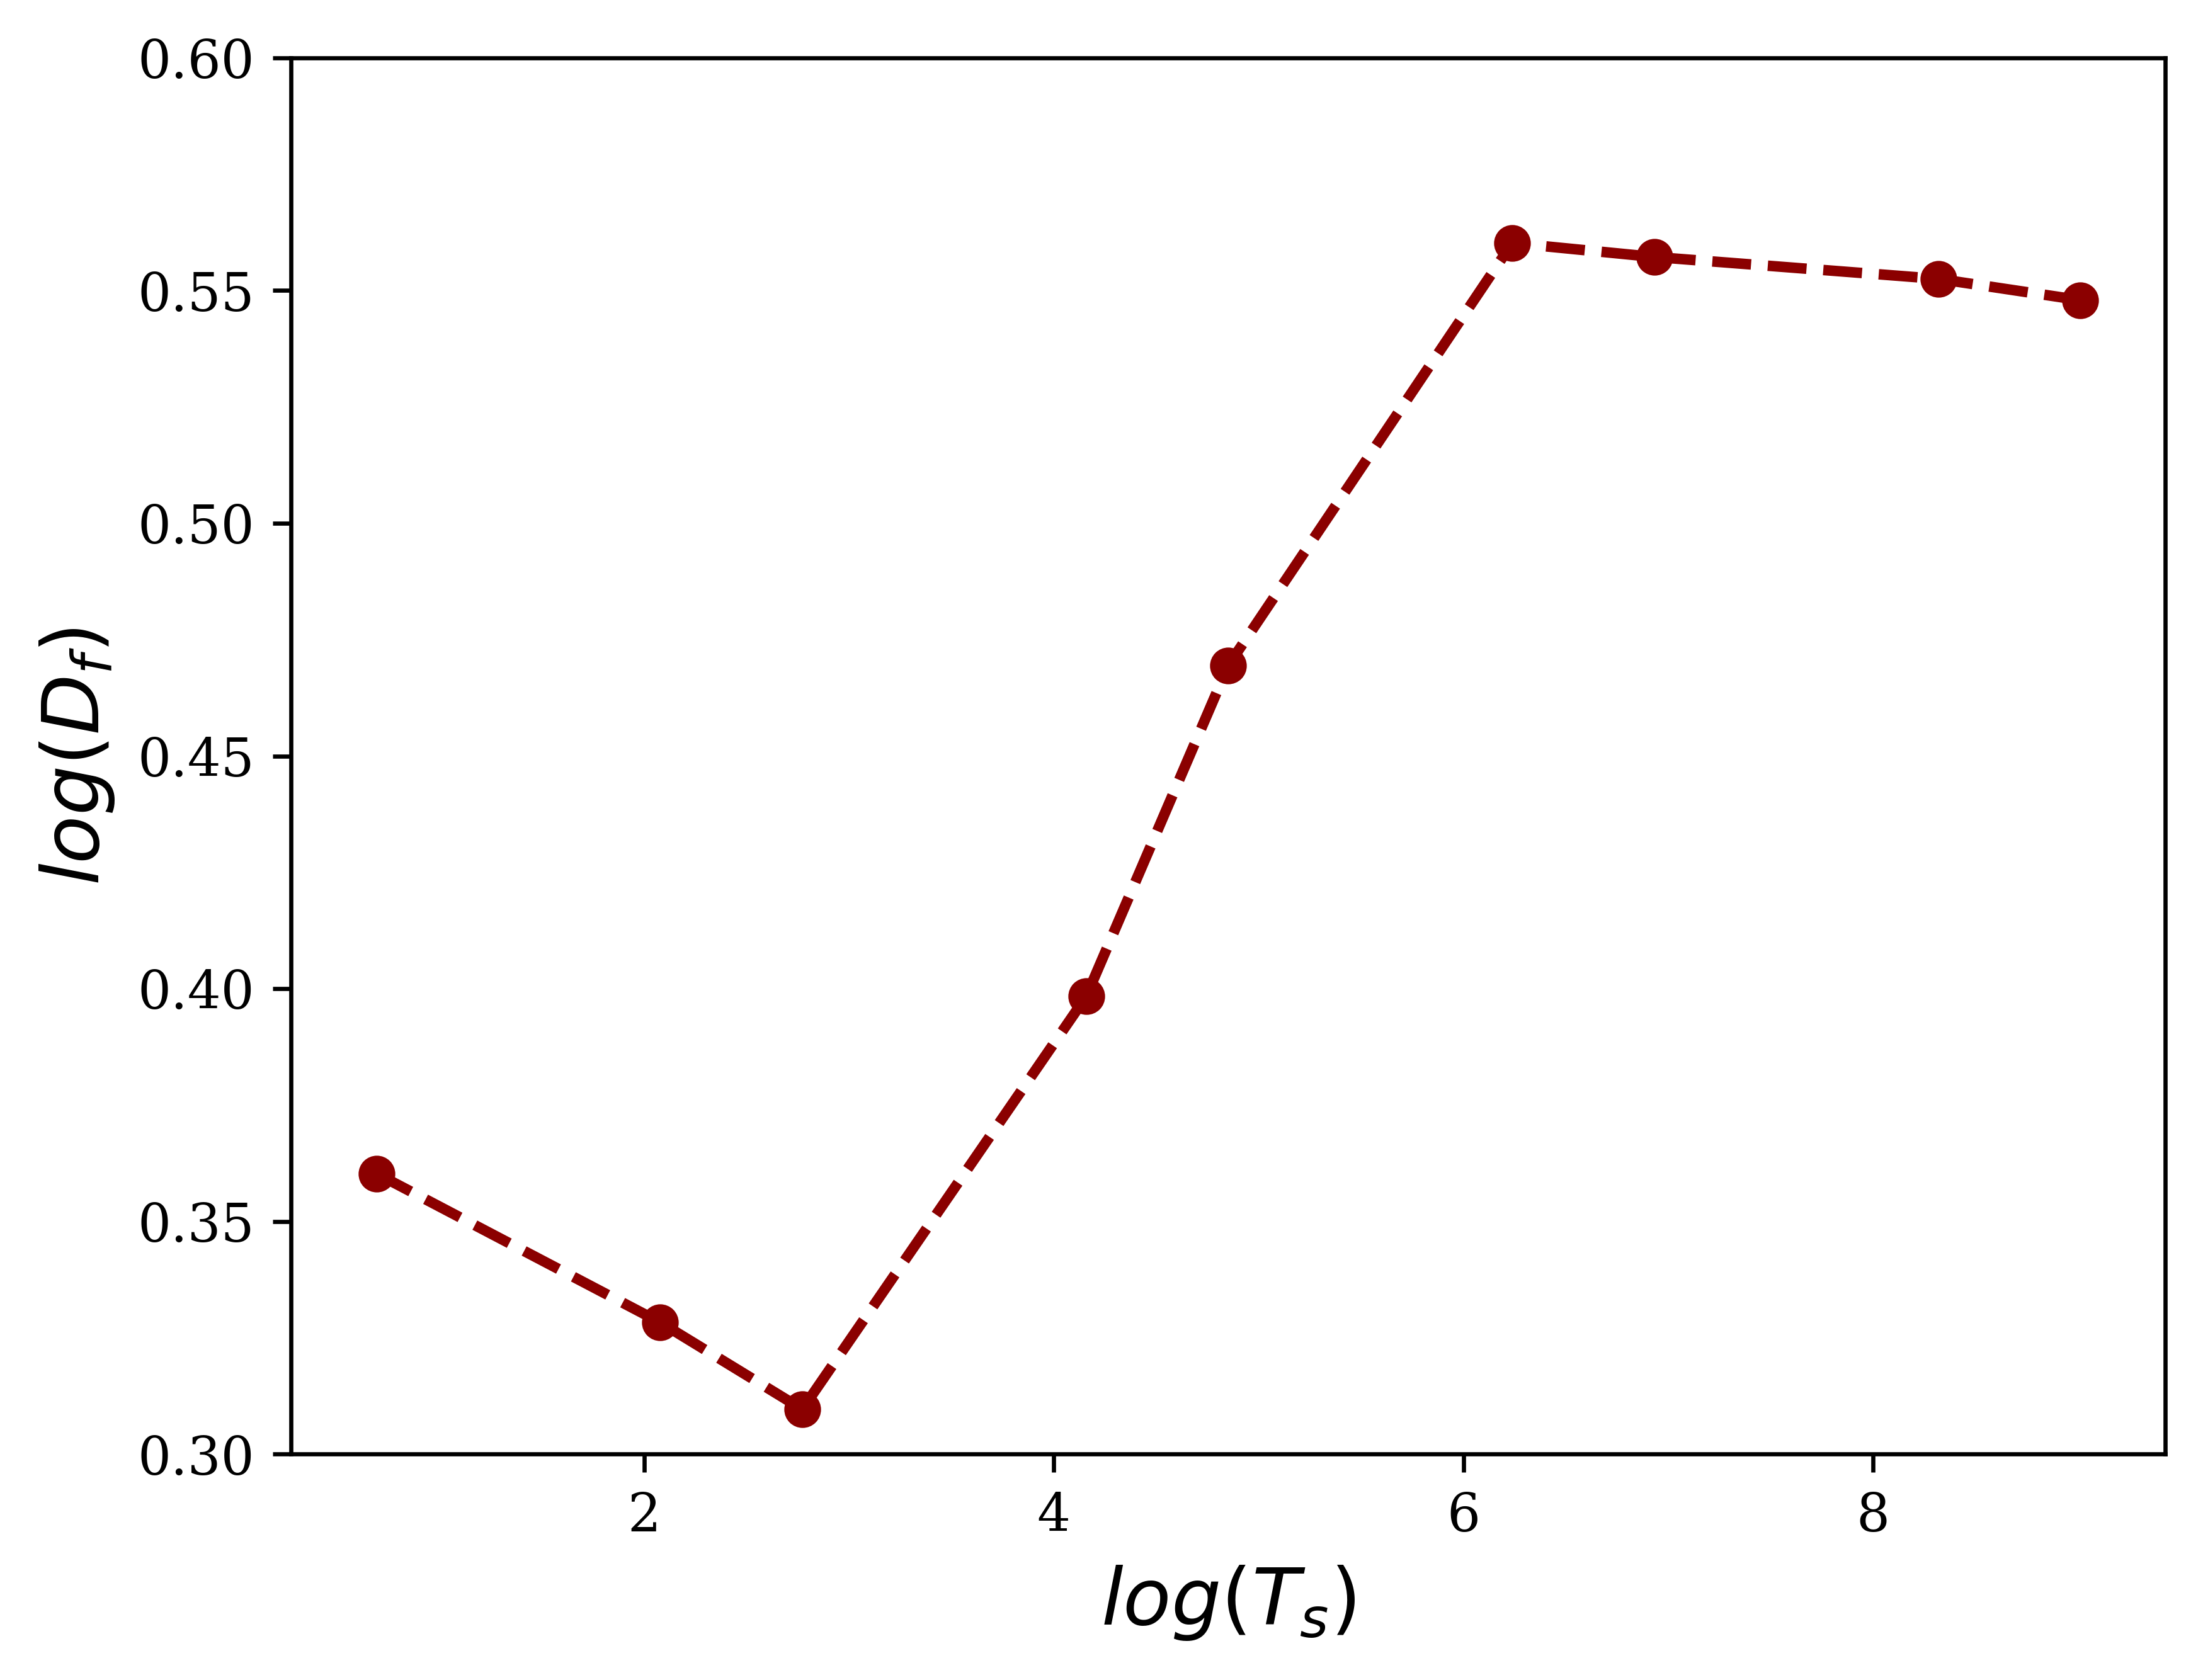

In [82]:
plt.figure(dpi = 600)
plt.plot(np.log(sorted(DFCS.keys())[:-1]),np.log(fdm),'o--', color = 'darkred')
plt.xlabel(r'$log(T_{s})$')
plt.ylabel(r'$log(D_{f})$')
plt.ylim(0.3,0.60)

In [90]:
type(lrgs)

numpy.ndarray

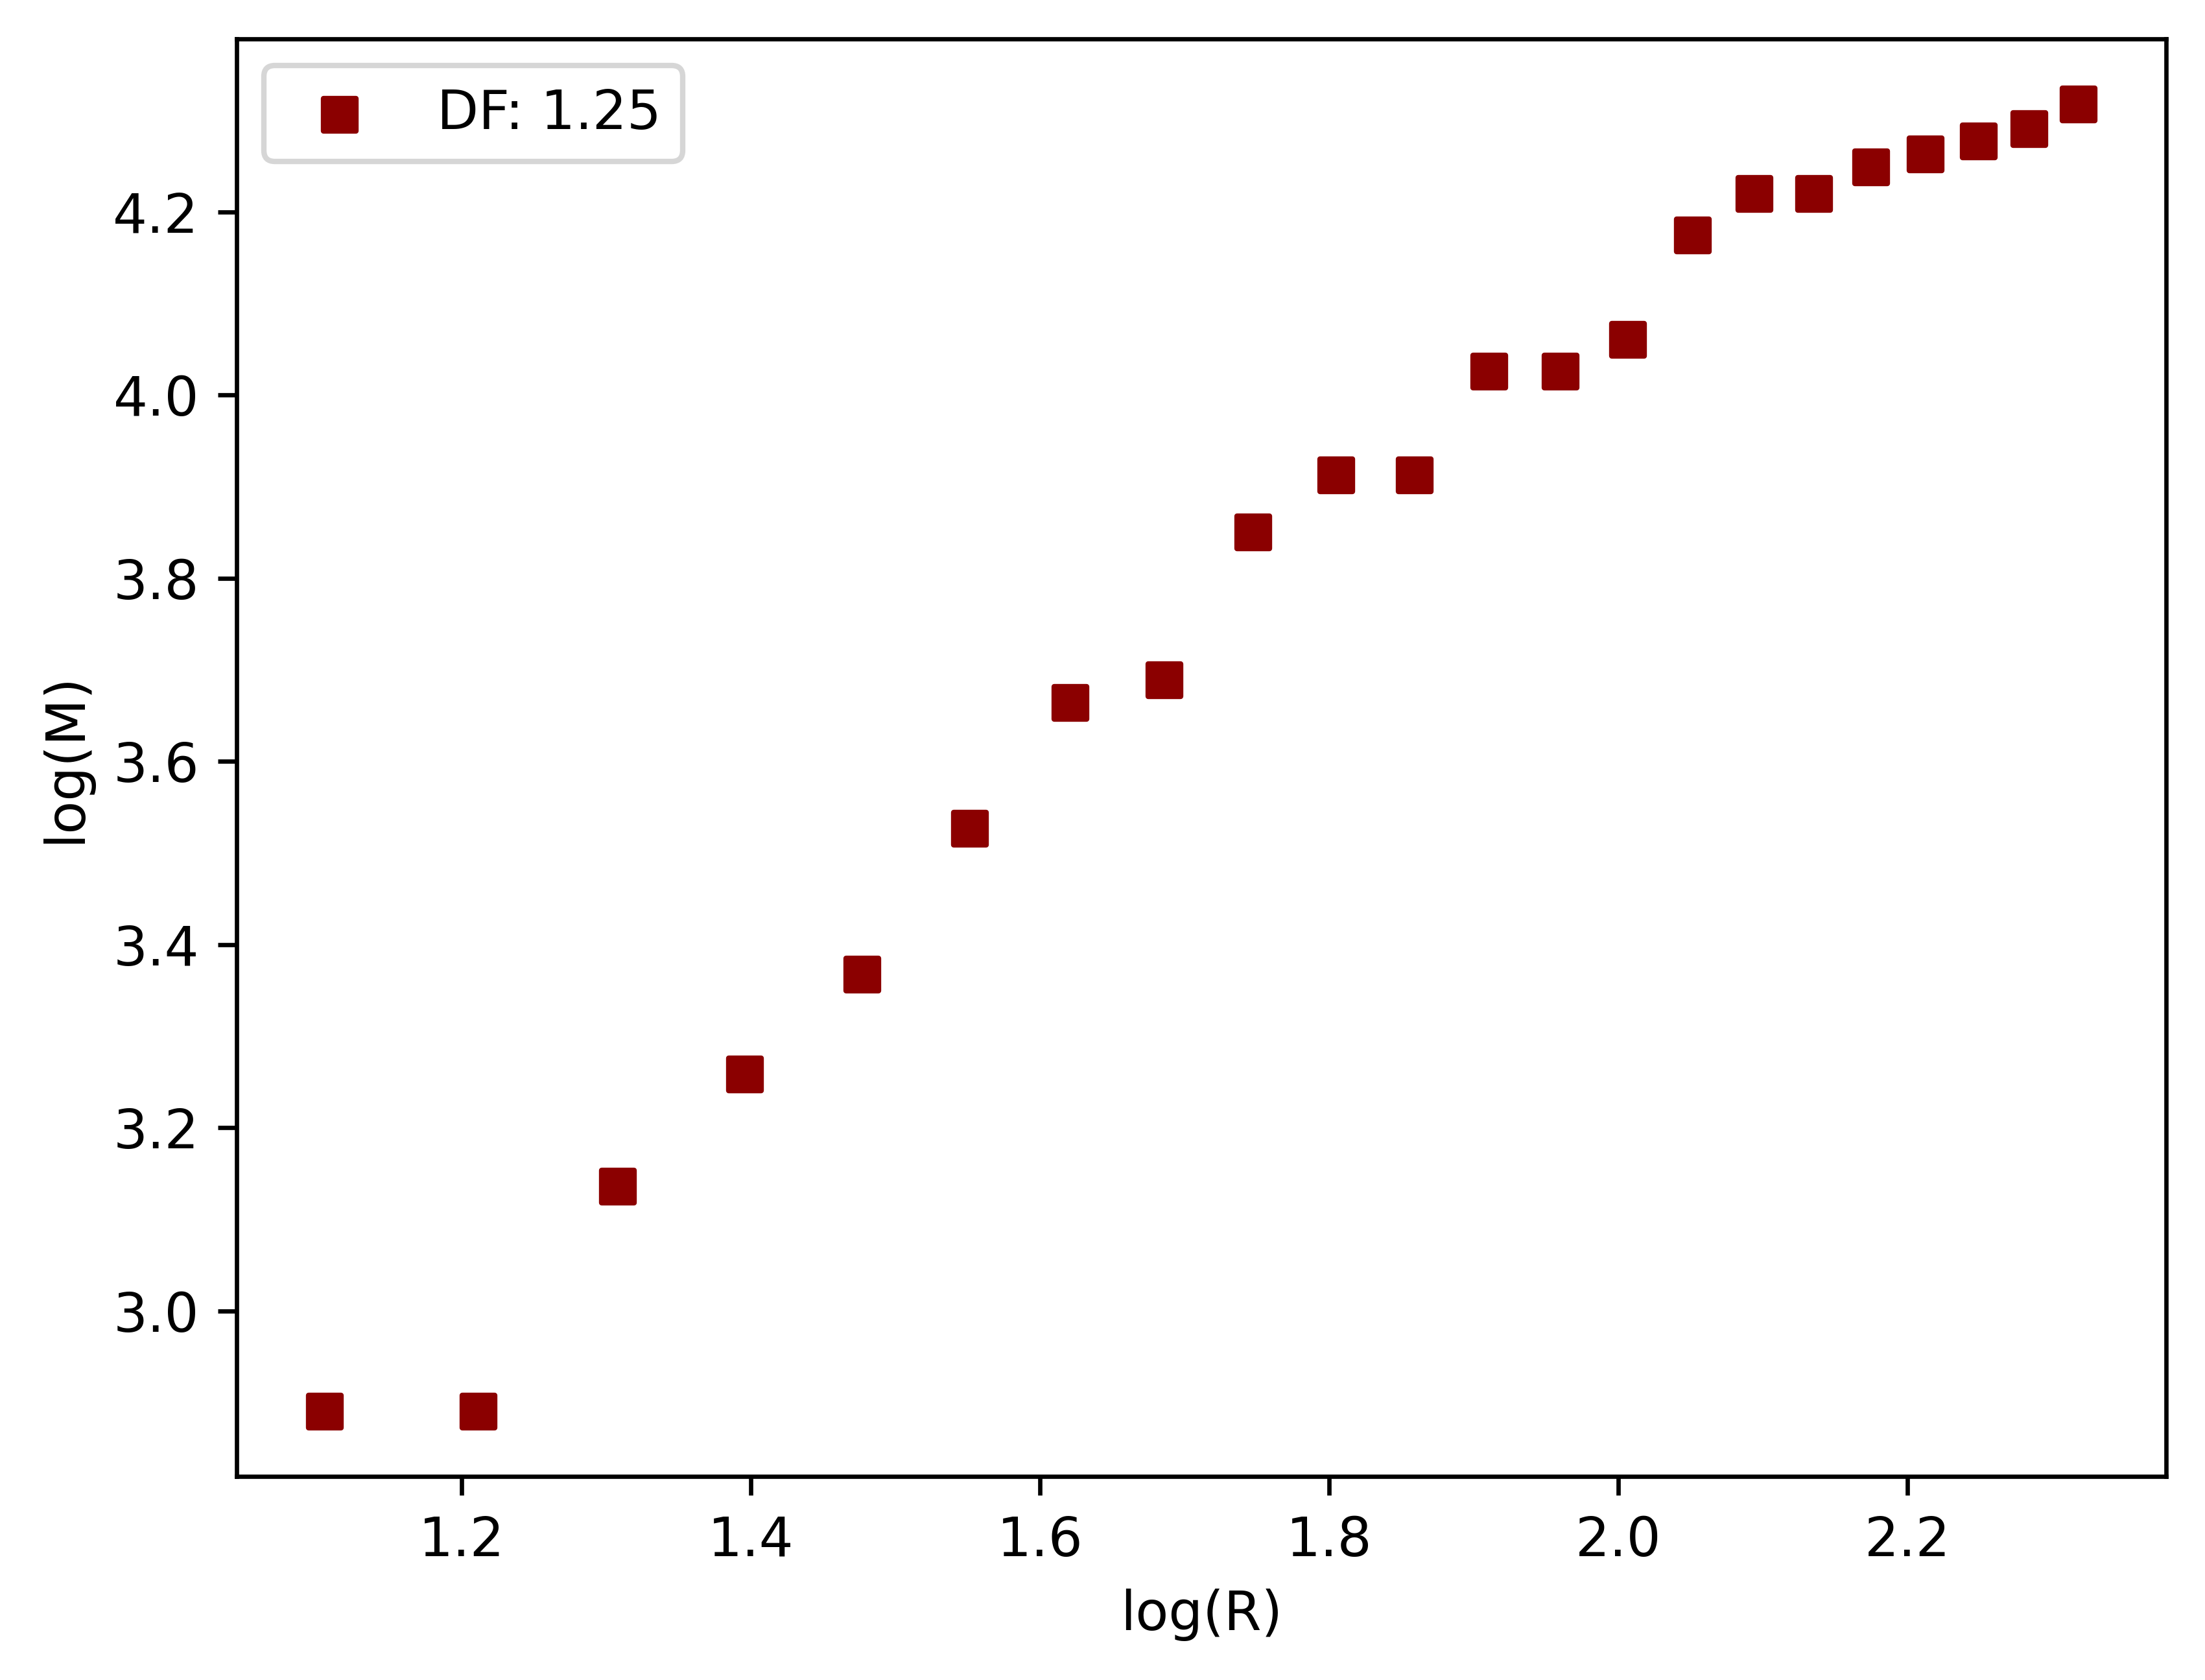

Text(0, 0.5, 'Z ')

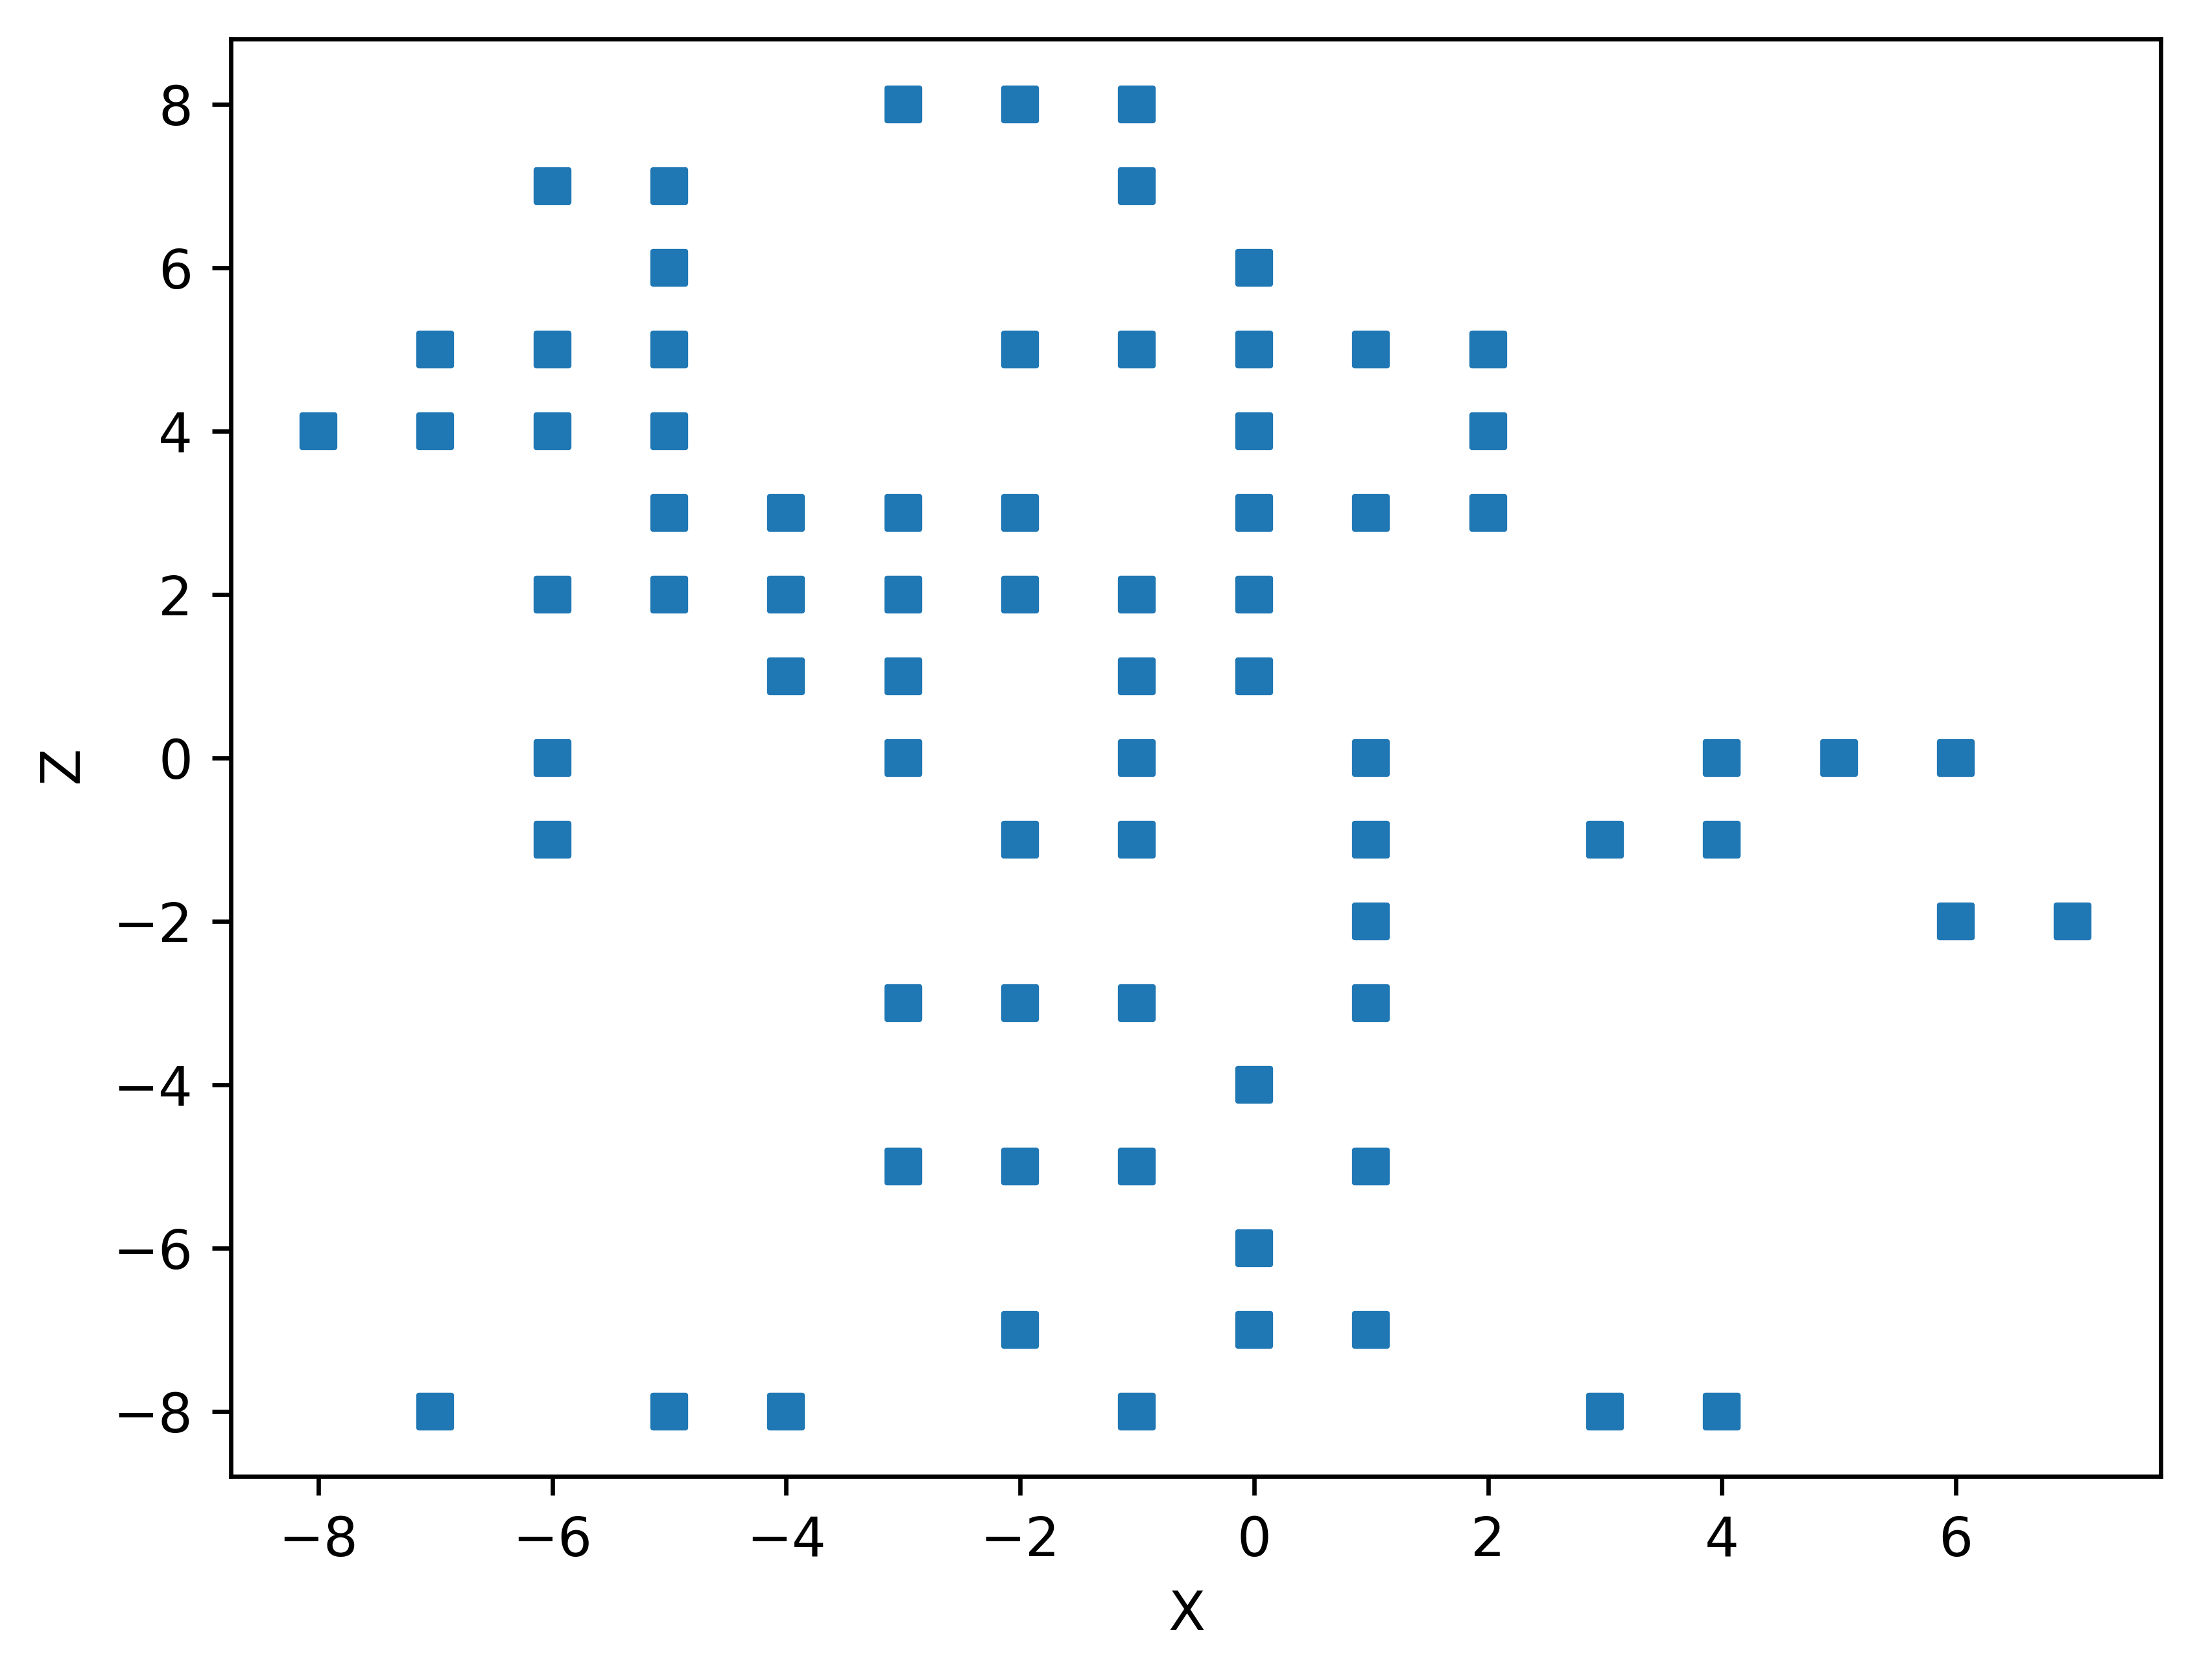

In [11]:
plt.figure(dpi = 600)
plt.scatter(lrgs,lNs, marker = 's', color = 'darkred', label = f'DF: {Df[-1]:.2f}')
plt.xlabel('log(R)')
plt.ylabel('log(M)')
plt.legend(loc = 'best')
plt.show()

# Plotting

plt.figure(dpi = 600)
plt.scatter(xv, zv, marker = 's')
plt.xlabel('X ')
plt.ylabel('Z ')

In [291]:
cs_s = np.linspace(-72,72,9)

In [292]:
cs_s

array([-72., -54., -36., -18.,   0.,  18.,  36.,  54.,  72.])

In [108]:
df = DFCS[8192][0]

In [59]:
coords = np.column_stack((xv, zv))
cm = np.mean(coords, axis=0)

In [64]:
m = coords - cm

In [66]:
m.shape

(256, 2)

In [67]:
np.sum((coords - cm)**2, axis=1)

array([   7.26875305,   21.36250305,   46.10469055,   55.00312805,
         30.51094055,    6.12031555,   22.54219055,   28.49531555,
         42.55781555,   78.80000305,   36.44844055,   10.33906555,
        104.19062805,   27.69062805,   44.95625305,   77.94844055,
         21.39375305,   93.69844055,   92.51094055,   36.88594055,
         38.93281555,   14.83125305,   38.79219055,   60.70625305,
        135.23750305,    9.93281555,   56.60469055,   31.64375305,
        105.13594055,   58.35469055,  106.29219055,   72.65156555,
        126.33906555,  122.03437805,  119.08906555,   57.50312805,
         90.84687805,   13.19062805,  100.55000305,  111.40156555,
         46.91719055,  135.98750305,   67.45625305,  181.08125305,
         10.87812805,    7.47187805,  205.12812805,   36.90937805,
        146.13594055,  152.73750305,  135.04219055,   83.65156555,
        218.27656555,  120.14375305,  213.62812805,  246.32344055,
        119.02656555,  231.17500305,  107.24531555,   56.08125

In [121]:
def calculate_mr(xv, zv):
    
    Rs = []
    Ns = []
    coords = np.column_stack((xv, zv))
    cm = np.mean(coords, axis=0)

    # Calcular a distância máxima do centro de massa ao ponto mais distante
    max_distance = np.max(np.sqrt(np.sum((coords - cm)**2, axis=1)))

    # Definir as escalas usando a distância máxima
    raies = np.linspace(0, max_distance, num=30)
    #print(max_distance)

    for r in raies:
  
        # Filtrar pontos cuja distância ao centro de massa é menor ou igual a scale
        distances_to_cm = np.sqrt(np.sum((coords - cm)**2, axis=1))
        points_within_scale = coords[distances_to_cm <= r]

        if len(points_within_scale) > 0:

            Rs.append(r)
            Ns.append(len(points_within_scale))
    
    Rs = np.array(Rs)
    Ns = np.array(Ns)
    
    Rs0 = Rs[Ns!=0]
    Ns0 = Ns[Ns!=0]
    #print(Rs0)
    # Realizar o ajuste log-log
    log_Rs = np.log(Rs0)
    log_Ns = np.log(Ns0)
    
    return log_Rs, log_Ns

def power_law(x, a, b):
    return a * x + b



In [149]:
Df_for_section = {}
for j in range(0,len(DFCS[8192])):
    df = DFCS[8192][j]
    
    for k in cs_s:
        print(k)
        xv = df['x'][df['y']==k].tolist()
        zv = df['z'][df['y']==k].tolist()


        LR = LinearRegression()
        Rs, Ns = calculate_mr(xv,zv)
        j = 0
        mr2 = 0
        for i in range(1,10,1):
            LR.fit(Rs[:-i].reshape(-1,1),Ns[:-i])
            r2 = r2_score(Ns[:-i], LR.predict(Rs[:-i].reshape(-1,1)))
            if(r2 >mr2):
                mr2 = r2
                j = i
        LR.fit(Rs[:-j].reshape(-1,1),Ns[:-j])
        Dimensao_Fractal = LR.coef_[0]


        if k in Df_for_section.keys():
            Df_for_section[k].append(Dimensao_Fractal)
        else:
            Df_for_section[k] = [Dimensao_Fractal]


        """ 
        coords = np.column_stack((xv, zv))
        cm = np.mean(coords, axis=0)

        plt.scatter(xv, zv, marker = 's', label = i)
        plt.scatter(cm[0],cm[1], marker= 'o', color = 'darkred')
        plt.xlabel('X ')
        plt.ylabel('Z ')
        plt.legend(loc = 'best')
        plt.show()


        plt.figure(dpi = 600)
        plt.scatter(Rs, Ns)
        plt.plot(Rs[:-10], LR.predict(Rs[:-10].reshape(-1,1)), label=f'DF: {Dimensao_Fractal}',c = 'red')
        plt.legend(loc = 'best')
        plt.show() """



-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90.0
-90.0
-72.0
-54.0
-36.0
-18.0
0.0
18.0
36.0
54.0
72.0
90

In [150]:
Df_for_section

{-90.0: [2.107877815385523,
  1.904958345382093,
  2.024833594388628,
  1.7431118267900645,
  2.157918146675309,
  2.0585268539930244,
  2.0170865767501174,
  1.690079571416473,
  1.8368776818261354,
  2.0387663338985678,
  1.886367744383185,
  2.0860774250595937,
  1.9926893255021045,
  1.7624539936480461,
  1.7835841594823512,
  2.409981521746331,
  1.8362052190180405,
  2.0657939732814925,
  2.07003940290006,
  1.7567212618188608,
  1.831844307506731,
  1.6199242093300434,
  1.7301927227822442,
  1.9064400334116496,
  1.8635292668002998,
  2.0186060856722987,
  1.6920342498691507,
  2.1666693561282893,
  2.2380851444594114,
  2.0492693482313844,
  1.7328683858113254,
  1.995659530336737,
  1.9816568511290686,
  1.780822916718241,
  1.8036484083700337,
  2.167470591177272,
  1.8397045579755964,
  3.073273294517568,
  1.8356517648200272,
  2.1418457640532202,
  1.8369351136483438,
  1.7946246822113157,
  1.7724016581029558,
  2.1422749886788837,
  1.827750978376866,
  2.01366260871731

In [156]:
Df_for_cross_med = {}
for i in sorted(Df_for_section.keys()):
    l = np.array(Df_for_section[i])
    lm = np.mean(l)
    st = np.std(l)
 
    Df_for_cross_med[i] = [lm,st]


In [157]:
Df_for_cross_med

{-90.0: [1.9496770670554389, 0.22956379217684542],
 -72.0: [1.9021312813475433, 0.1096084684151085],
 -54.0: [1.9314795230631259, 0.20632118406540143],
 -36.0: [1.924888279194216, 0.10460907629506982],
 -18.0: [1.9113427940978542, 0.1464355130239385],
 0.0: [1.9673721660451557, 0.15389024352984781],
 18.0: [1.937637764790621, 0.19704104698015842],
 36.0: [1.918521965556462, 0.12707814079760718],
 54.0: [1.9358440909001013, 0.1975627280121939],
 72.0: [1.9382311420501255, 0.1402845292658456],
 90.0: [1.8808172598306907, 0.13630757798281304]}

In [159]:
mean_of_first_values = np.mean([value[0] for value in Df_for_cross_med.values()])


In [161]:
mean_of_first_values

1.9524984984325775

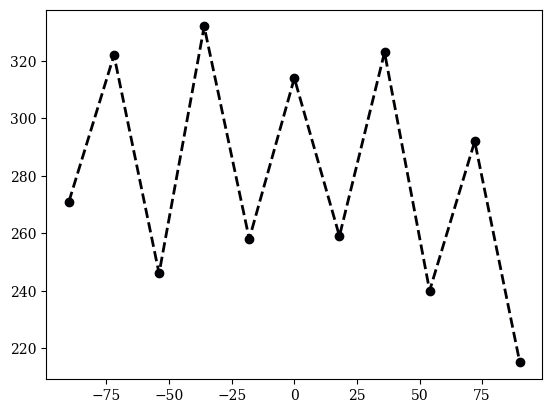

In [222]:
df = DFCS[8192][0]
m = []
for k in cs_s:
    xv = df['x'][df['y']==k].tolist()
    m.append(len(xv))
    
    
plt.plot(cs_s, m, 'o--')

plt.show()

In [294]:
for ts in sorted(DFCS.keys()):
    dn = './df_ts_'+str(ts)+'.dat'
    Df_for_section = {}
    m_for_section = {}
    print(dn)
    for j in range(0,len(DFCS[ts])):
        df = DFCS[ts][j]
        
        for k in cs_s:
            #print(k)
            xv = df['x'][df['y']==k].tolist()
            zv = df['z'][df['y']==k].tolist()

            LR = LinearRegression()
            Rs, Ns = calculate_mr(xv,zv)
            j = 0
            mr2 = 0
            for i in range(1,10,1):
                LR.fit(Rs[:-i].reshape(-1,1),Ns[:-i])
                r2 = r2_score(Ns[:-i], LR.predict(Rs[:-i].reshape(-1,1)))
                if(r2 >mr2):
                    mr2 = r2
                    j = i
            LR.fit(Rs[:-j].reshape(-1,1),Ns[:-j])
            Dimensao_Fractal = LR.coef_[0]


            if k in Df_for_section.keys():
                Df_for_section[k].append(Dimensao_Fractal)
            else:
                Df_for_section[k] = [Dimensao_Fractal]

    Df_for_cross_med = {}
    for i in sorted(Df_for_section.keys()):
        l = np.array(Df_for_section[i])
        lm = np.mean(l)
        st = np.std(l)
    
        Df_for_cross_med[i] = [lm,st/np.sqrt(50)]

    val = []
    #Escrever o dicionário em um arquivo .dat
    with open(dn, 'w') as file:
        with open('dfs.dat', 'a') as fid:
            for key, value in Df_for_cross_med.items():
                file.write(f"{key}\t{value[0]}\t{value[1]}\n")

            mean_of_first_values = np.mean([value[0] for value in Df_for_cross_med.values()])
            # Calculating the standard deviation of the first values
            std_dev = np.std([value[0] for value in Df_for_cross_med.values()])

            # Calculating the error as standard deviation over the square root of the number of samples
            error = std_dev / np.sqrt(50)


            fid.write(f'{ts}\t{mean_of_first_values}\t{error}\n')



./df_ts_2.dat
./df_ts_8.dat
./df_ts_16.dat
./df_ts_64.dat
./df_ts_128.dat
./df_ts_512.dat
./df_ts_1024.dat
./df_ts_4096.dat
./df_ts_8192.dat
./df_ts_16384.dat


In [4]:
x = np.loadtxt('./dfs.dat')

In [20]:
x[-1]

array([8.19200000e+03, 1.92708576e+00, 3.17789184e-03])

In [188]:
np.delete(x,-1)

array([2.00000000e+00, 1.73216970e+00, 8.00000000e+00, 1.69487712e+00,
       1.60000000e+01, 1.72869539e+00, 6.40000000e+01, 1.88032060e+00,
       1.28000000e+02, 1.90680510e+00, 5.12000000e+02, 1.91927558e+00,
       1.02400000e+03, 1.92986417e+00, 4.09600000e+03, 1.94125545e+00,
       8.19200000e+03, 1.92708576e+00, 1.63840000e+04])

Text(0, 0.5, '$F_{D}$')

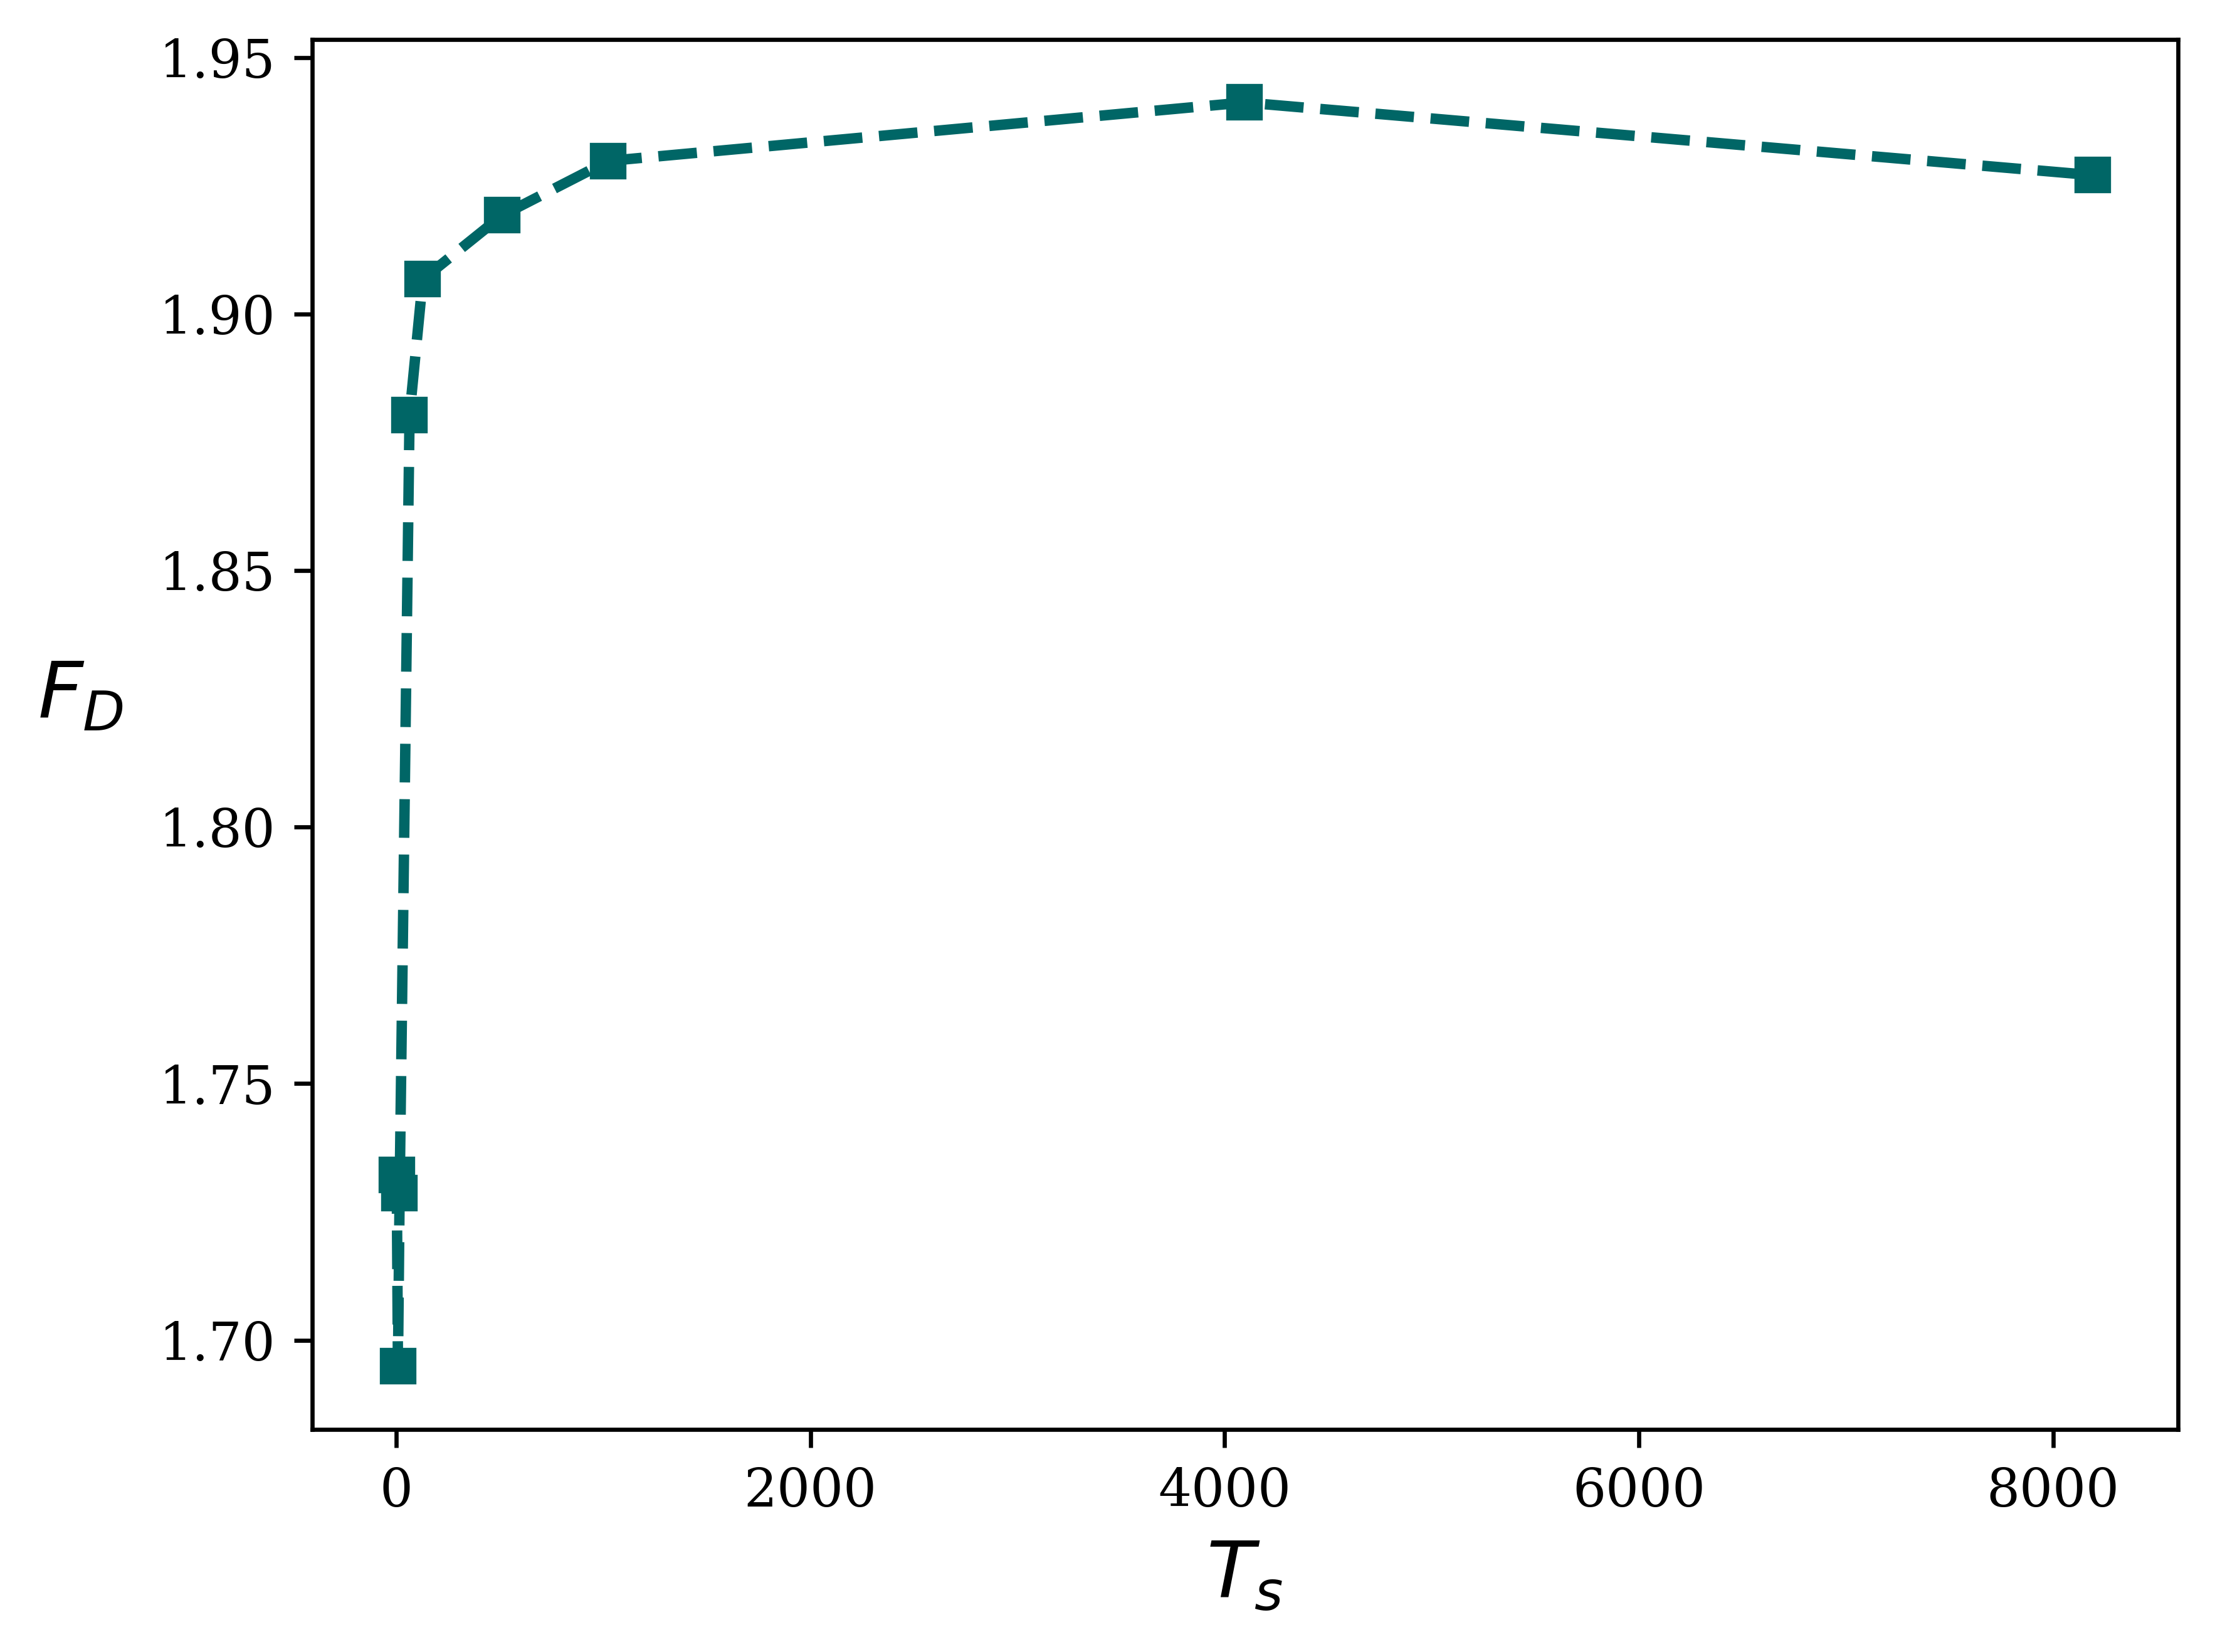

In [229]:
plt.figure(dpi = 600)
plt.plot((x.T[0]), x.T[1], 's--', c ='#006666')
plt.xlabel(r"$T_{s}$")
plt.ylabel(r"$F_{D}$", rotation = 0, labelpad=15)

In [282]:
dfm = np.round(x.T[1],2)

In [239]:
y1 = np.mean(x.T[1][0:2])*np.ones(len(x.T[1]))
x1 = np.linspace(0,10,len(x.T[1]))
y2 = np.mean(x.T[1][-3:-1])*np.ones(len(x.T[1]))

In [256]:
colors =

NameError: name 'color' is not defined

(0.0, 10.0)

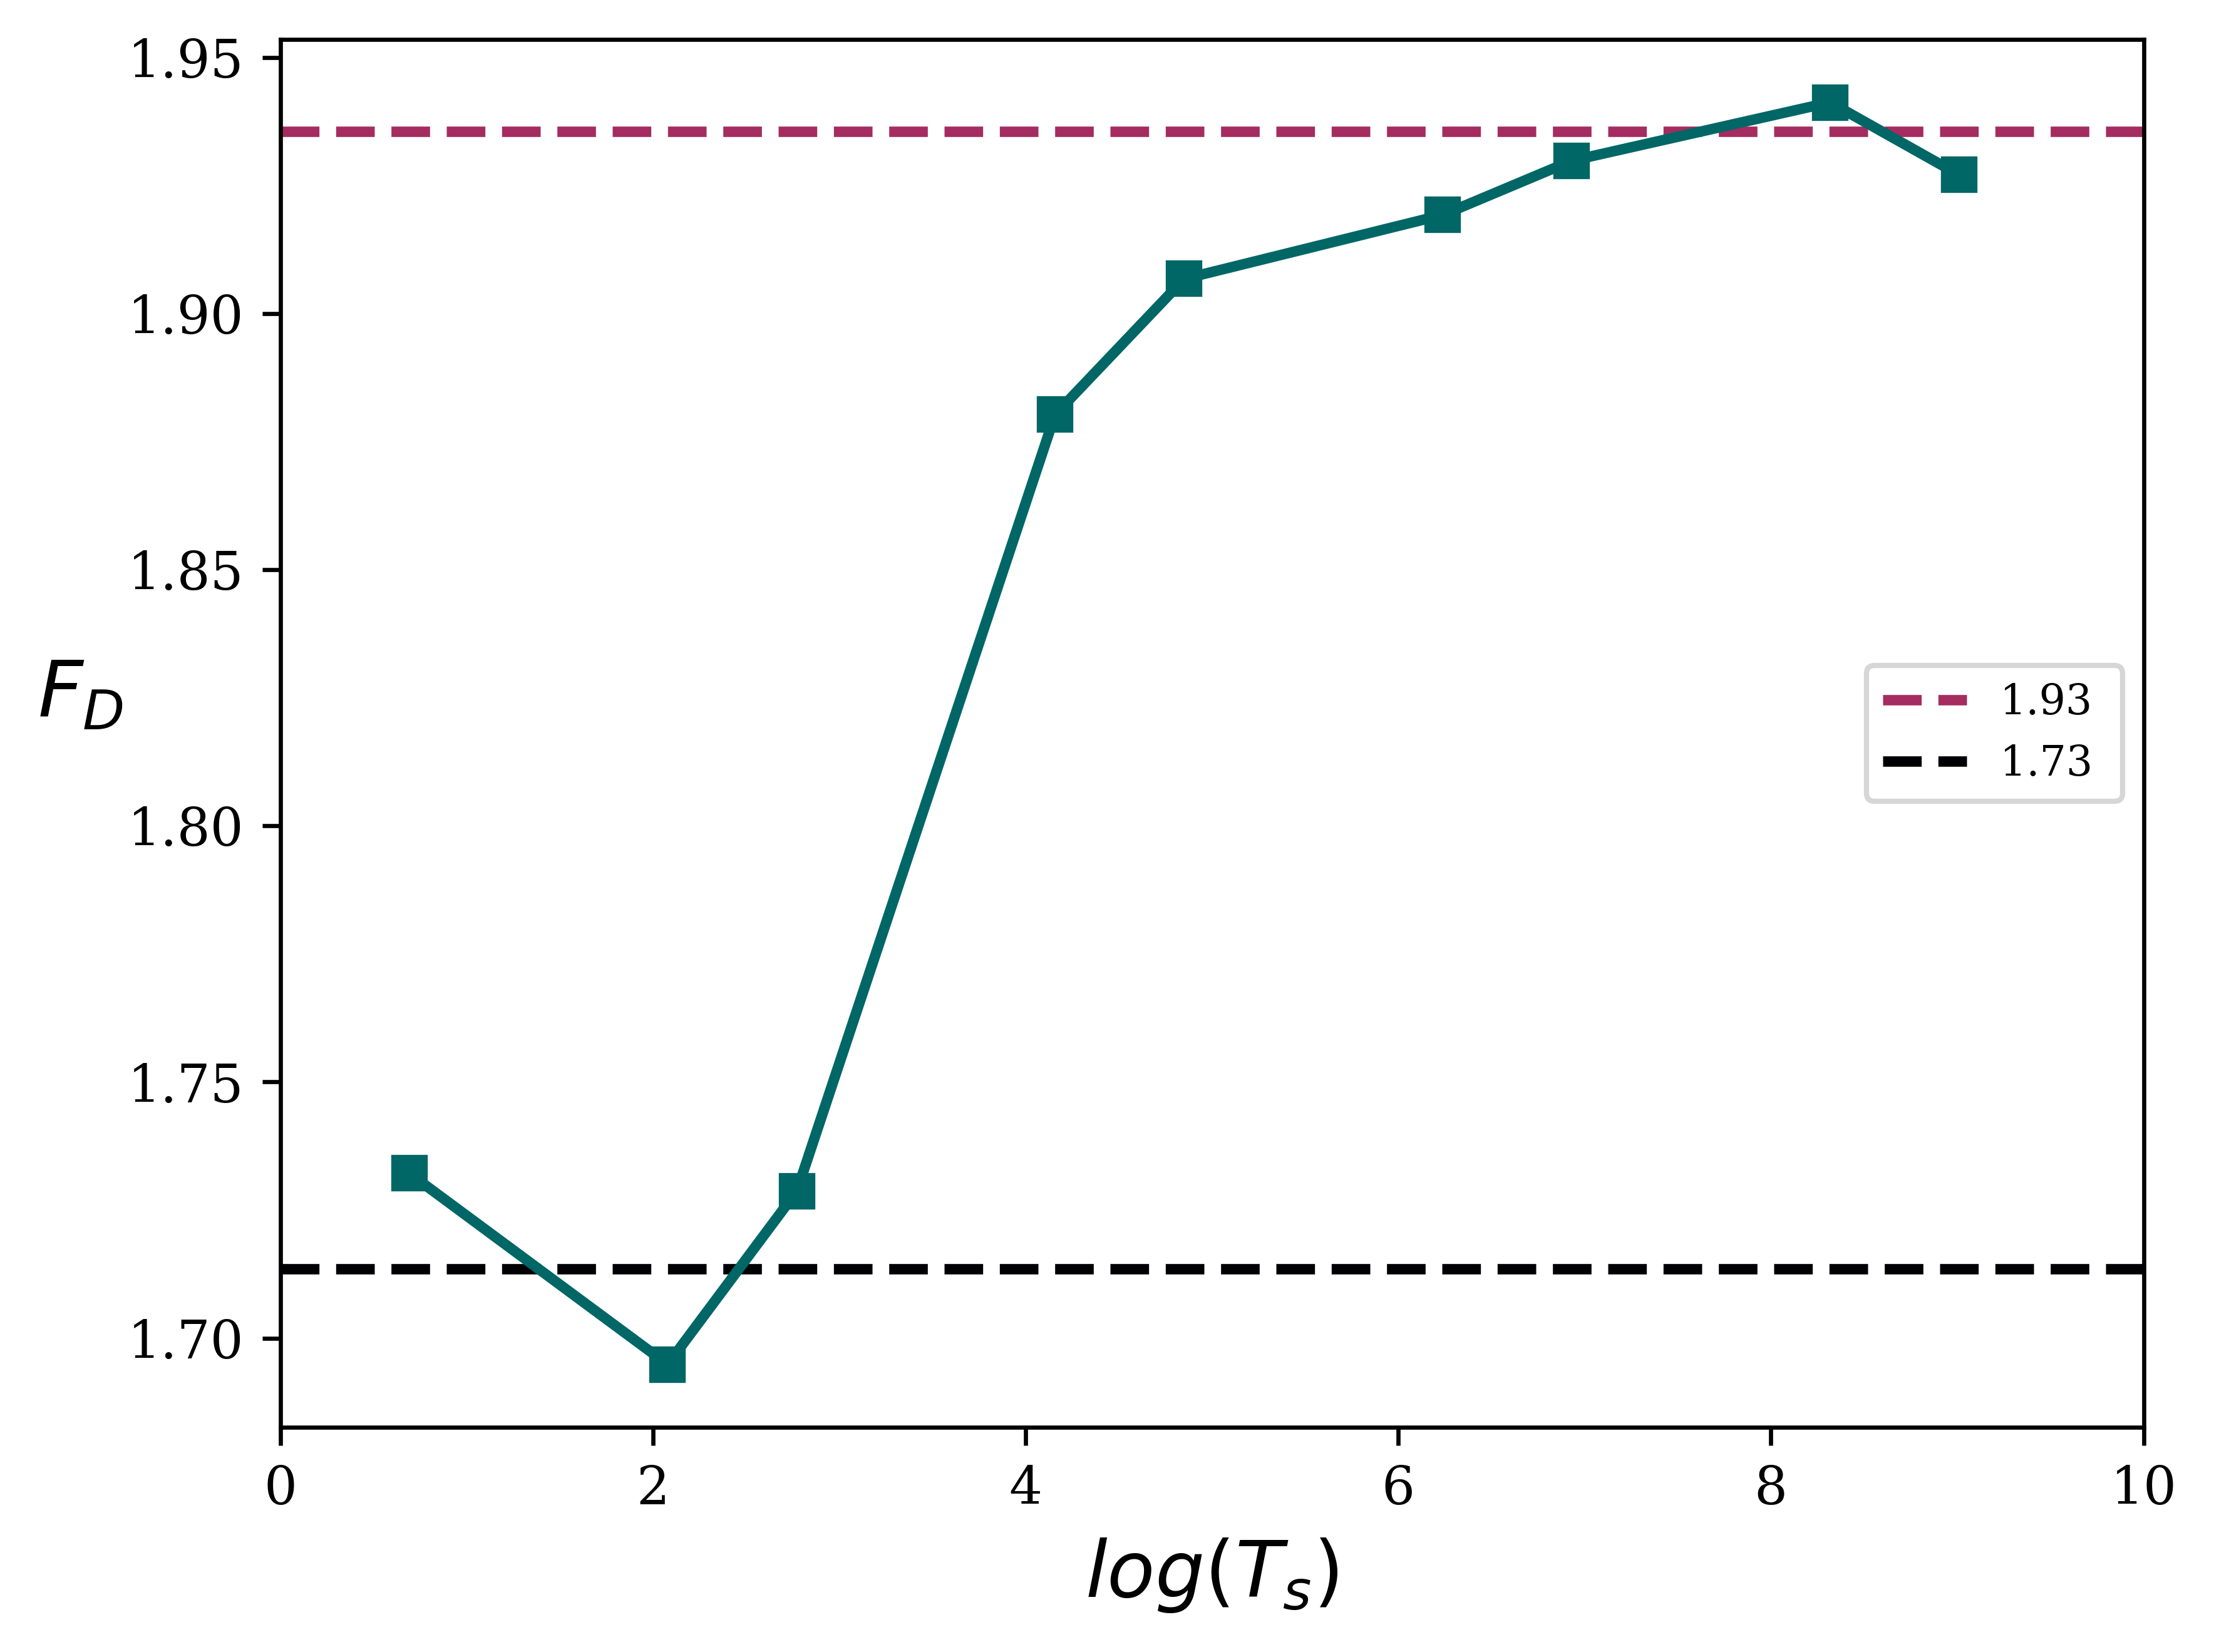

In [289]:
plt.figure(dpi = 600)
plt.plot(x1,y2,'--',c = colors[4], label = f'{dfm[-1]}')
plt.plot(x1,y1,'--',c = colors[0], label = f'{dfm[0]} ')
plt.plot(np.log(x.T[0]), x.T[1], 's-',c = '#006666')
plt.xlabel(r"$log(T_{s})$")
plt.ylabel(r"$F_{D}$", rotation = 0, labelpad=9)
plt.legend(loc = 'center right')
# Adicionando a legenda preta
plt.xlim(0,10)

In [86]:
import os
import fnmatch

def listar_arquivos_dat(diretorio):
    # Lista todos os arquivos no diretório
    arquivos = os.listdir(diretorio)

    # Filtra apenas os arquivos que terminam com ".dat"
    arquivos_dat = fnmatch.filter(arquivos, '*.dat')

    return arquivos_dat

# Substitua 'caminho/do/seu/diretorio' pelo caminho do diretório que você deseja listar
diretorio_alvo = './'

# Lista os arquivos .dat no diretório especificado
arquivos_dat = listar_arquivos_dat(diretorio_alvo)

# Imprime a lista de arquivos .dat
for arquivo in arquivos_dat:
    print(arquivo)


dfs.dat
df_ts_1024.dat
df_ts_128.dat
df_ts_16.dat
df_ts_16384.dat
df_ts_2.dat
df_ts_4096.dat
df_ts_512.dat
df_ts_64.dat
df_ts_8.dat
df_ts_8192.dat


In [81]:
sorted(arquivos_dat)

['df_ts_1024.dat',
 'df_ts_128.dat',
 'df_ts_16.dat',
 'df_ts_16384.dat',
 'df_ts_2.dat',
 'df_ts_4096.dat',
 'df_ts_512.dat',
 'df_ts_64.dat',
 'df_ts_8.dat',
 'df_ts_8192.dat',
 'dfs.dat']

In [204]:
lts = [1024, 128, 16,2, 4096, 512, 64, 8, 8192]

In [205]:
l = sorted(lts)

In [91]:
arquivos_dat

['df_ts_1024.dat',
 'df_ts_128.dat',
 'df_ts_16.dat',
 'df_ts_2.dat',
 'df_ts_4096.dat',
 'df_ts_512.dat',
 'df_ts_64.dat',
 'df_ts_8.dat',
 'df_ts_8192.dat']

In [88]:
del arquivos_dat[0]

In [202]:
arq = ['df_ts_2.dat','df_ts_8.dat','df_ts_16.dat','df_ts_64.dat','df_ts_128.dat','df_ts_512.dat','df_ts_1024.dat','df_ts_4096.dat','df_ts_8192.dat']

./df_ts_2.dat
./df_ts_8.dat
./df_ts_16.dat
./df_ts_64.dat
./df_ts_128.dat
./df_ts_512.dat
./df_ts_1024.dat
./df_ts_4096.dat
./df_ts_8192.dat


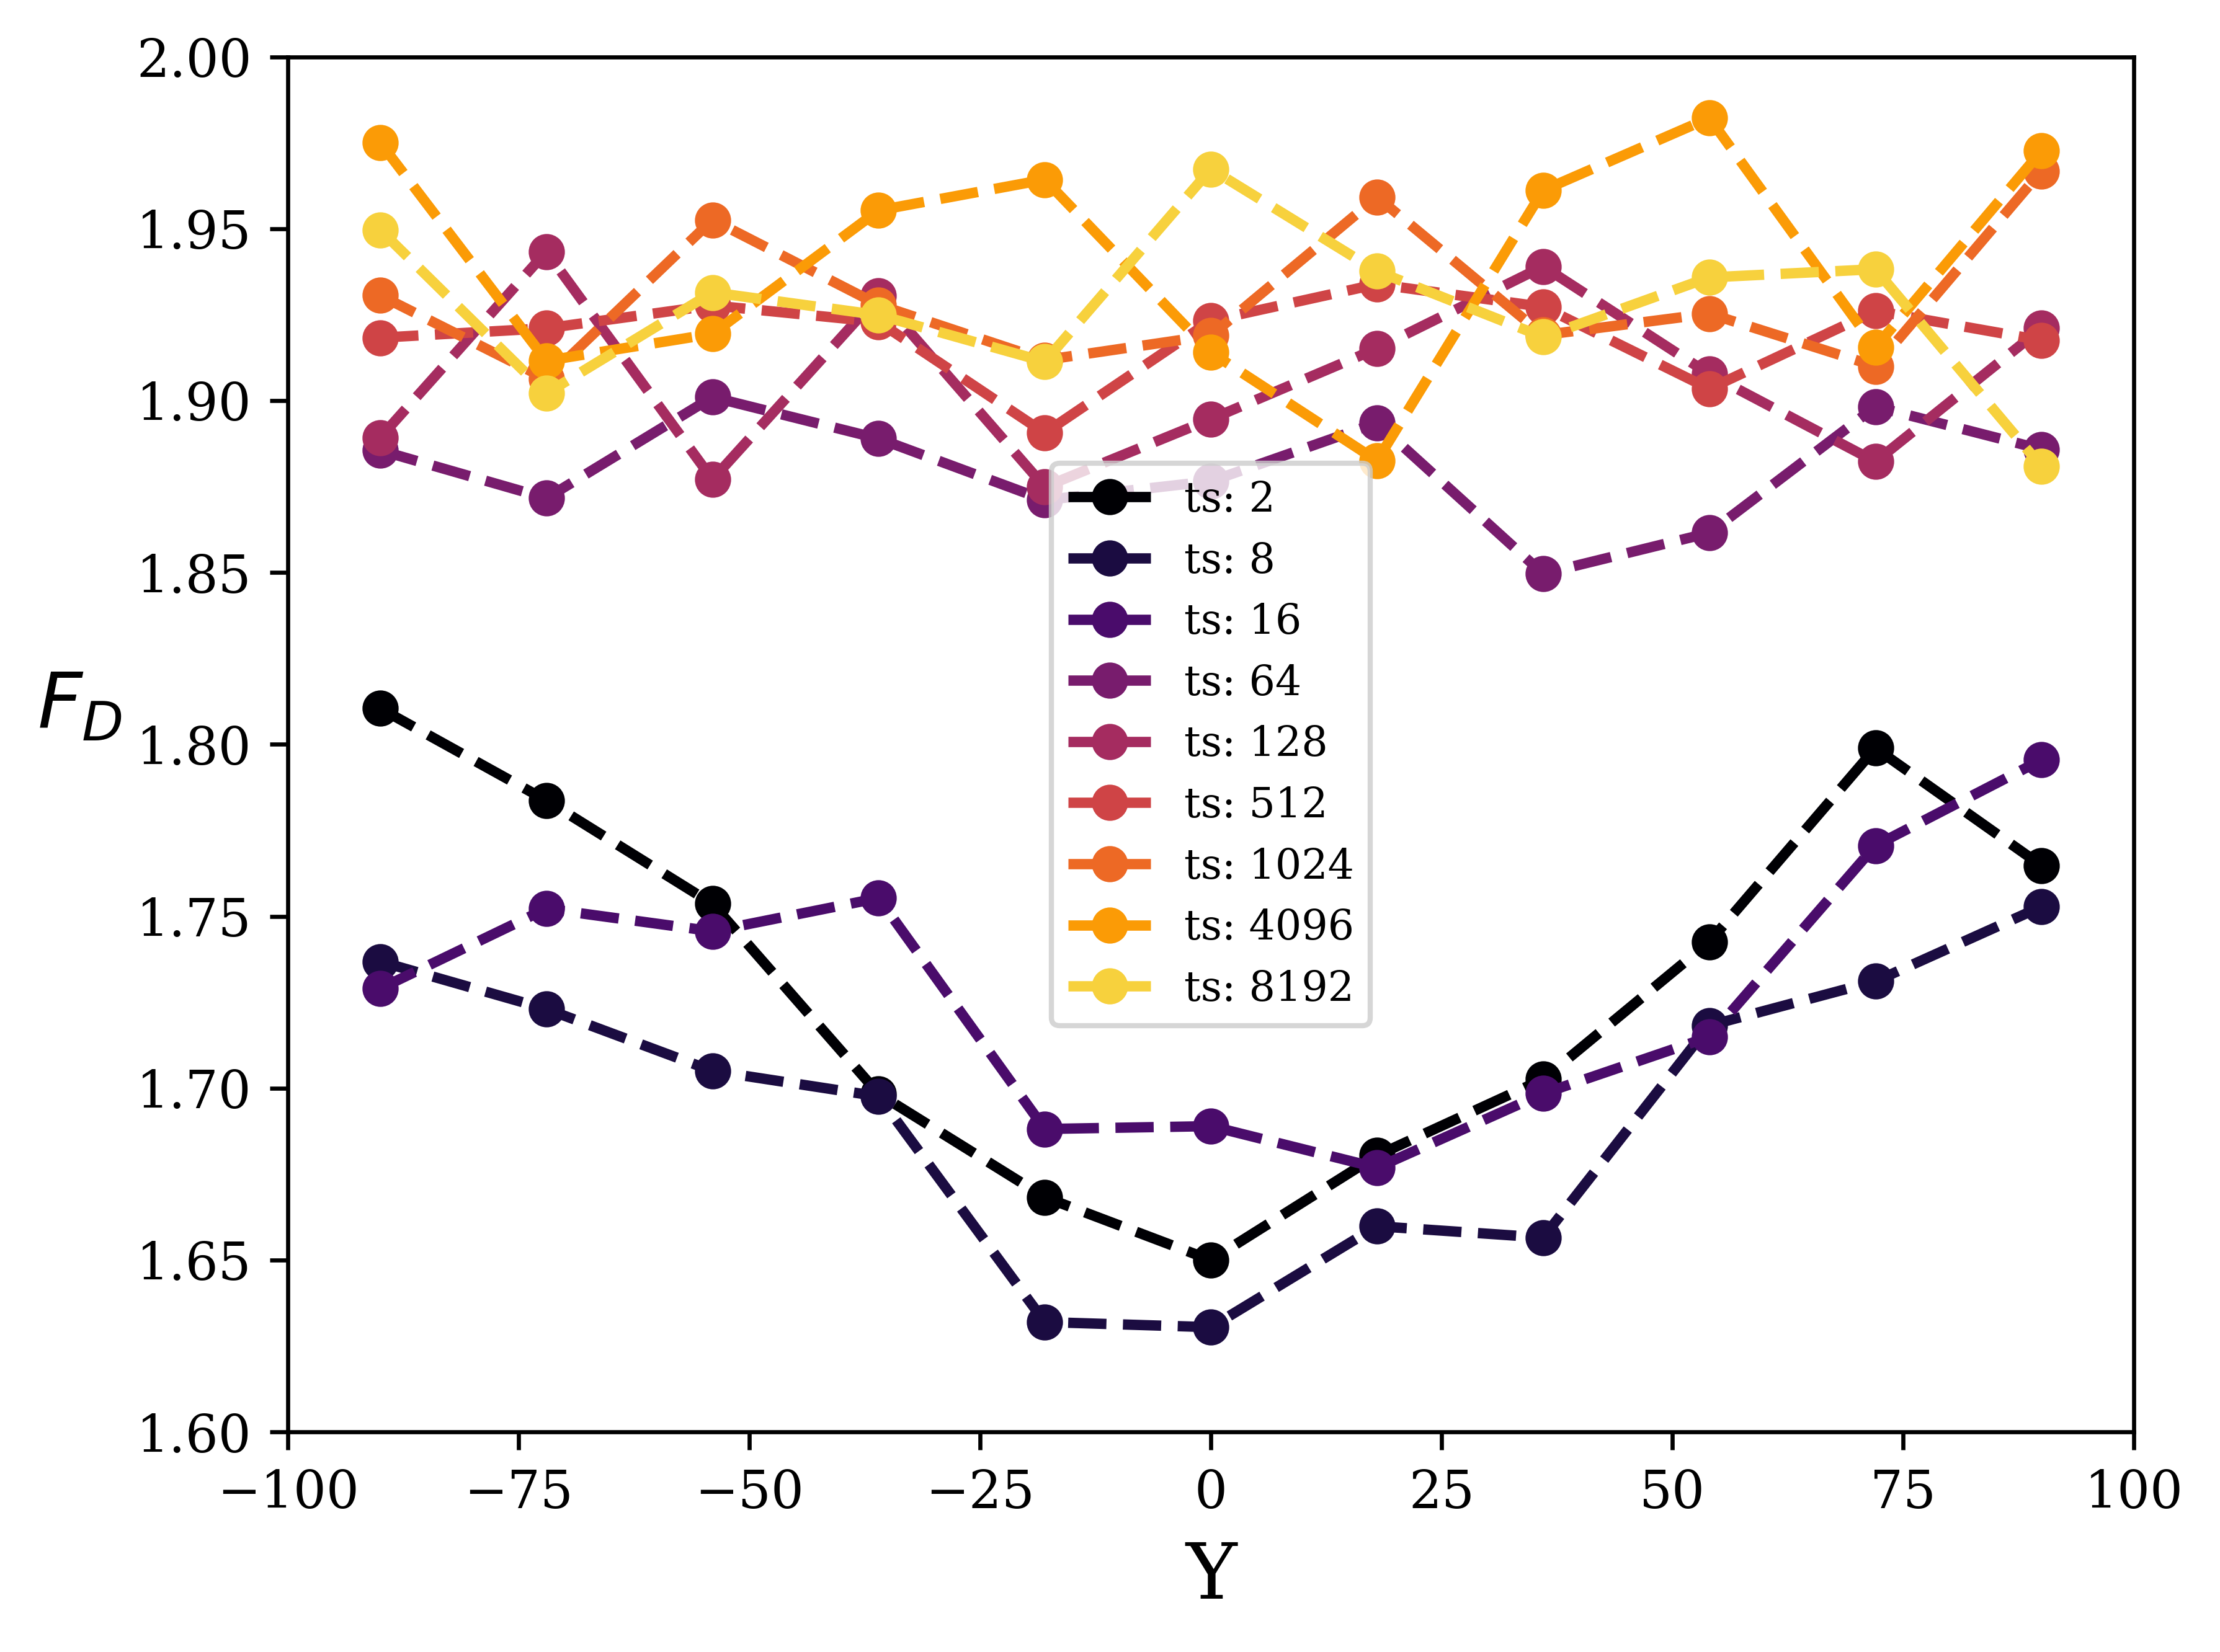

In [288]:
j = 0
stds = []
plt.figure(dpi = 600)
for i in arq:

    fn = './' + i
    print(fn)
    dt = np.loadtxt(fn)
    plt.plot(cs_s, dt.T[1], 'o--', label = f'ts: {l[j]}')
    stds.append(np.std(dt.T[1]))
    j+=1

plt.xlabel(r"Y")
plt.ylabel(r"$F_{D}$", rotation = 0,  labelpad=11)
plt.legend(loc = 'best')

plt.xlim(-100,100)
plt.ylim(1.6,2)
plt.show()

In [207]:
stds

[0.05256486425510535,
 0.041206719267134706,
 0.03665608891579649,
 0.015147921600445492,
 0.02367906009488569,
 0.011690810624996927,
 0.01973026450000063,
 0.03183033546160232,
 0.022471088722168794]

In [41]:
dt.T[1]

array([1.81048224, 1.78371951, 1.7536395 , 1.69837335, 1.66830871,
       1.6500242 , 1.6804337 , 1.70263449, 1.74258523, 1.79891996,
       1.76474578])

In [40]:
np.std(dt.T[1])

0.05256486425510535

In [193]:
0.2/np.sqrt(50)

0.0282842712474619

In [223]:
print(df)

         id    uid   x   y  z              file_path
0       uid      0   0  -9  0  ts_8192_seed_6385.dat
1       uid      0   0  -8  0  ts_8192_seed_6385.dat
2       uid      0   0  -7  0  ts_8192_seed_6385.dat
3       uid      0   0  -6  0  ts_8192_seed_6385.dat
4       uid      0   0  -5  0  ts_8192_seed_6385.dat
...     ...    ...  ..  .. ..                    ...
538987  uid  29943 -10  28 -5  ts_8192_seed_6385.dat
538988  uid  29943 -10  29 -5  ts_8192_seed_6385.dat
538989  uid  29943 -10  30 -5  ts_8192_seed_6385.dat
538990  uid  29943 -10  31 -5  ts_8192_seed_6385.dat
538991  uid  29943 -10  32 -5  ts_8192_seed_6385.dat

[56545 rows x 6 columns]


In [112]:
import plotly.graph_objs as go
import plotly.offline as pyo

# Suponha que estas são suas listas de coordenadas
x_list = df['x'].tolist()
y_list = df['y'].tolist()
z_list = df['z'].tolist()
# Criar uma instância de Scatter3d
trace = go.Scatter3d(
    x=x_list,
    y=y_list,
    z=z_list,
    mode='markers',
    marker=dict(
        size=5,  # Tamanho dos marcadores
        color=z_list,  # Cor baseada nos valores de z_list
        colorscale='Viridis',  # Escolha uma paleta de cores
        opacity=0.8  # Transparência dos marcadores
    )
)

# Definindo o layout do gráfico
layout = go.Layout(
    title='Gráfico 3D de dispersão com suas listas',
    scene=dict(
        xaxis=dict(title='Eixo X'),
        yaxis=dict(title='Eixo Y'),
        zaxis=dict(title='Eixo Z')
    )
)

# Criar figura e adicionar o trace
fig = go.Figure(data=[trace], layout=layout)
fig.show()

In [26]:
ys, counts = np.unique(DFCS[8192][0]['y'].tolist(), return_counts=True)
ys = sorted(ys)

In [30]:
counts[1:-2]

array([259, 259, 332, 332, 263, 263, 329, 329, 271, 271, 330, 330, 267,
       267, 324, 324, 255, 255, 332, 332, 259, 259, 318, 318, 252, 252,
       322, 322, 263, 263, 329, 329, 272, 272, 327, 327, 250, 250, 317,
       317, 258, 258, 316, 316, 246, 246, 323, 323, 257, 257, 329, 329,
       274, 274, 340, 340, 273, 273, 327, 327, 269, 269, 332, 332, 255,
       255, 317, 317, 245, 245, 302, 302, 236, 236, 302, 302, 248, 248,
       321, 321, 258, 258, 326, 326, 264, 264, 324, 324, 267, 267, 335,
       335, 269, 269, 325, 325, 252, 252, 314, 314, 246, 246, 326, 326,
       266, 266, 323, 323, 255, 255, 307, 307, 251, 251, 321, 321, 259,
       259, 327, 327, 247, 247, 303, 303, 246, 246, 316, 316, 264, 264,
       318, 318, 248, 248, 323, 323, 255, 255, 312, 312, 256, 256, 320,
       320, 250, 250, 311, 311, 257, 257, 315, 315, 240, 240, 302, 302,
       245, 245, 305, 305, 241, 241, 296, 296, 235, 235, 295, 295, 237,
       237, 292, 292, 230, 230, 285, 285, 225, 225, 287, 287, 23

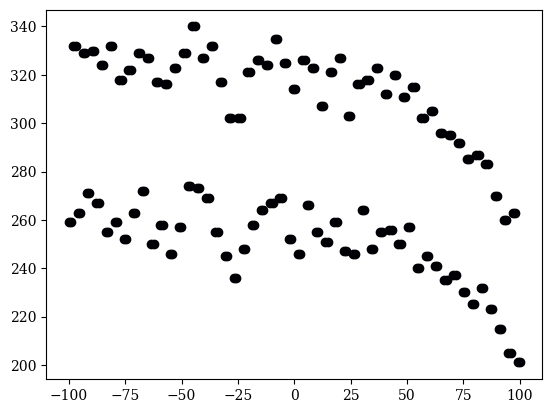

In [31]:
plt.scatter(np.linspace(-100,100,len(counts[1:-2])), counts[1:-2])

In [107]:
counts

array([307, 259, 259, 332, 332, 263, 263, 329, 329, 271, 271, 330, 330,
       267, 267, 324, 324, 255, 255, 332, 332, 259, 259, 318, 318, 252,
       252, 322, 322, 263, 263, 329, 329, 272, 272, 327, 327, 250, 250,
       317, 317, 258, 258, 316, 316, 246, 246, 323, 323, 257, 257, 329,
       329, 274, 274, 340, 340, 273, 273, 327, 327, 269, 269, 332, 332,
       255, 255, 317, 317, 245, 245, 302, 302, 236, 236, 302, 302, 248,
       248, 321, 321, 258, 258, 326, 326, 264, 264, 324, 324, 267, 267,
       335, 335, 269, 269, 325, 325, 252, 252, 314, 314, 246, 246, 326,
       326, 266, 266, 323, 323, 255, 255, 307, 307, 251, 251, 321, 321,
       259, 259, 327, 327, 247, 247, 303, 303, 246, 246, 316, 316, 264,
       264, 318, 318, 248, 248, 323, 323, 255, 255, 312, 312, 256, 256,
       320, 320, 250, 250, 311, 311, 257, 257, 315, 315, 240, 240, 302,
       302, 245, 245, 305, 305, 241, 241, 296, 296, 235, 235, 295, 295,
       237, 237, 292, 292, 230, 230, 285, 285, 225, 225, 287, 28

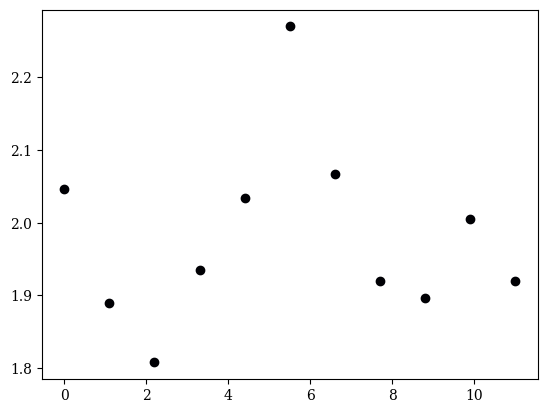

In [113]:
plt.scatter(np.linspace(0,len(Dfs),len(Dfs)),Dfs)

In [114]:
import statistics

In [116]:
type(Dfs)

list

In [120]:
np.std(Dfs)

0.1181601099351682

In [9]:
ys

[-100,
 -99,
 -98,
 -97,
 -96,
 -95,
 -94,
 -93,
 -92,
 -91,
 -90,
 -89,
 -88,
 -87,
 -86,
 -85,
 -84,
 -83,
 -82,
 -81,
 -80,
 -79,
 -78,
 -77,
 -76,
 -75,
 -74,
 -73,
 -72,
 -71,
 -70,
 -69,
 -68,
 -67,
 -66,
 -65,
 -64,
 -63,
 -62,
 -61,
 -60,
 -59,
 -58,
 -57,
 -56,
 -55,
 -54,
 -53,
 -52,
 -51,
 -50,
 -49,
 -48,
 -47,
 -46,
 -45,
 -44,
 -43,
 -42,
 -41,
 -40,
 -39,
 -38,
 -37,
 -36,
 -35,
 -34,
 -33,
 -32,
 -31,
 -30,
 -29,
 -28,
 -27,
 -26,
 -25,
 -24,
 -23,
 -22,
 -21,
 -20,
 -19,
 -18,
 -17,
 -16,
 -15,
 -14,
 -13,
 -12,
 -11,
 -10,
 -9,
 -8,
 -7,
 -6,
 -5,
 -4,
 -3,
 -2,
 -1,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83

In [15]:
x = DFCS[2][0]['x'][DFCS[2][0]['y'] == ys[0]].tolist()
z = DFCS[2][0]['z'][DFCS[2][0]['y'] == ys[0]].tolist()

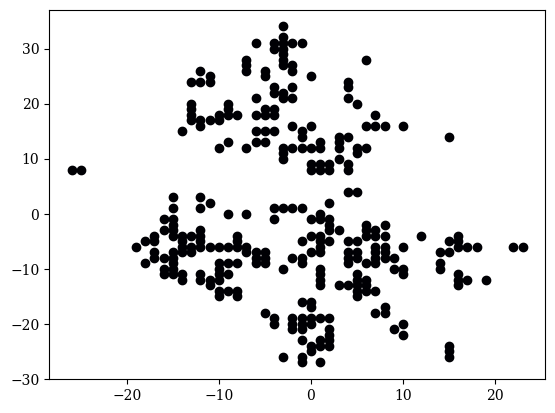

In [17]:
plt.scatter(x,z)